# Background

This project comes from [Kaggle](https://www.kaggle.com/joniarroba/noshowappointments). 

**Problem Statement**

We are interested to identify the possible reasons of no-show patients who had made doctor appointments.

**Data Overview**

This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row.

- `ScheduledDay` tells us on what day the patient set up their appointment.
- `Neighborhood` indicates the location of the hospital.
- `Scholarship` indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família.
- Be careful about the encoding of the last column: it says ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up.

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import urllib
from IPython.display import display

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
PROJECT_ROOT = '.'
IMAGES = os.path.join(PROJECT_ROOT, 'IMAGES')
DATA = os.path.join(PROJECT_ROOT, 'DATASETS')

if not os.path.isdir(IMAGES):
  os.mkdir(IMAGES)

if not os.path.isdir(DATA):
  os.mkdir(DATA)

def fetch_data(file_url, file_name, path):
  if not os.path.isdir(path):
    os.mkdir(path)
  file_path = os.path.join(path, file_name)
  urllib.request.urlretrieve(file_url, file_path)
  print('File is downloaded in: ', file_path)

def save_fig(image_name, path=IMAGES, dpi=300, fmt='png'):
  if not os.path.isdir(path):
    os.mkdir(path)
  image_path = os.path.join(path, image_name+'.'+fmt)
  plt.savefig(image_path, dpi=dpi, format=fmt)

# Fetch and Load Data

In [5]:
noshow_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59dd2e9a_noshowappointments-kagglev2-may-2016/noshowappointments-kagglev2-may-2016.csv'
fetch_data(noshow_url, 'noshow.csv', DATA)

File is downloaded in:  ./DATASETS/noshow.csv


In [6]:
# check the first 5 rows of data before reading in dataframe
!head -5 ./DATASETS/noshow.csv

PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
29872499824296,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
558997776694438,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
4262962299951,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
867951213174,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No


In [0]:
file_path = os.path.join(DATA, 'noshow.csv')
def load_nowshow_data(file_path=file_path):
  df = pd.read_csv(file_path, parse_dates=['ScheduledDay', 'AppointmentDay'], dtype={'PatientId': 'object', 'AppointmentID': 'object'})
  return df

noshow = load_nowshow_data()

# Data Wrangling


* General Properties


In [15]:
noshow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   PatientId       110527 non-null  object             
 1   AppointmentID   110527 non-null  object             
 2   Gender          110527 non-null  object             
 3   ScheduledDay    110527 non-null  datetime64[ns, UTC]
 4   AppointmentDay  110527 non-null  datetime64[ns, UTC]
 5   Age             110527 non-null  int64              
 6   Neighbourhood   110527 non-null  object             
 7   Scholarship     110527 non-null  int64              
 8   Hipertension    110527 non-null  int64              
 9   Diabetes        110527 non-null  int64              
 10  Alcoholism      110527 non-null  int64              
 11  Handcap         110527 non-null  int64              
 12  SMS_received    110527 non-null  int64              
 13  No-show       

In [14]:
noshow.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [17]:
noshow.duplicated().any()

False

There are 110,527 rows, and 14 columns in this dataset. There appeares to be no missing values. The columns consists of datatime, numerical and categorical types. There are no duplicated rows.

* Data cleaning

In [88]:
mask = noshow['AppointmentDay'].dt.date < noshow['ScheduledDay'].dt.date

noshow[mask]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_days
27033,7839272661752,5679978,M,2016-05-10 10:51:53+00:00,2016-05-09 00:00:00+00:00,38,RESISTÊNCIA,0,0,0,0,1,0,Yes,-1
55226,7896293967868,5715660,F,2016-05-18 14:50:41+00:00,2016-05-17 00:00:00+00:00,19,SANTO ANTÔNIO,0,0,0,0,1,0,Yes,-1
64175,24252258389979,5664962,F,2016-05-05 13:43:58+00:00,2016-05-04 00:00:00+00:00,22,CONSOLAÇÃO,0,0,0,0,0,0,Yes,-1
71533,998231581612122,5686628,F,2016-05-11 13:49:20+00:00,2016-05-05 00:00:00+00:00,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes,-6
72362,3787481966821,5655637,M,2016-05-04 06:50:57+00:00,2016-05-03 00:00:00+00:00,7,TABUAZEIRO,0,0,0,0,0,0,Yes,-1


There are 5 records show that patients' appointment day ahead of schedule day. This would be possible when it is emergency treatment and later on record their appointment date. But in this scenario, the No-show status would be 'No' instead of yes.

To mitigate obscure information, I decide to drop these records from the dataset.

In [0]:
inds = noshow[mask].index.values
noshow.drop(index=inds, axis=0, inplace=True)

# Exploratory Data Analysis

* What is the percentage of no-show in the entire dataset?
* Does the waiting time between schedule day and appointment day affect no-show portions?
* Does the scholarship lead to high no-show chances?
* Which neighbourhood has the highest no-show counts?
* Which disease has the highest no-show counts? 
* Does the usage of sms reminder help to lower no-show rate?

## No-show Status

**Question: What is the percentage of no-show in the entire dataset?**

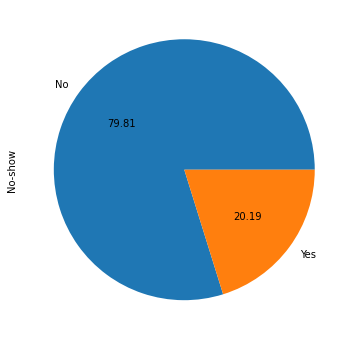

In [170]:
noshow['No-show'].value_counts().plot(kind='pie', autopct='%.2f', figsize=(8, 6))
save_fig('Pie_of_No_Show_Stauts')

79.81% patients showed up for the appointment, and 20.19% of patients did not show up.

## No-show status by Waiting Time

**Questions: How long is the average waiting time in days?**

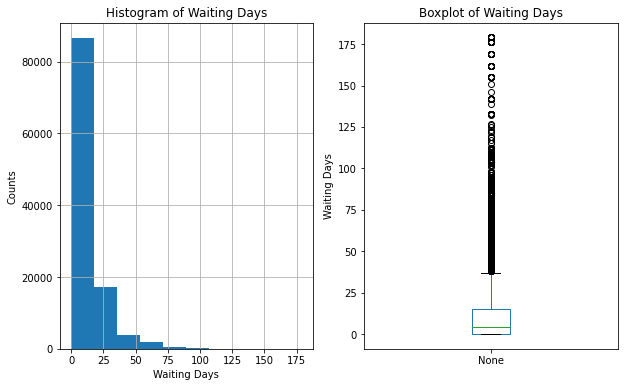

In [96]:
noshow_waiting = (noshow['AppointmentDay'].dt.date- noshow['ScheduledDay'].dt.date).dt.days

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
noshow_waiting.hist(ax=ax1)
ax1.set(title='Histogram of Waiting Days', xlabel='Waiting Days', ylabel='Counts')
noshow_waiting.plot(kind='box', ax=ax2)
ax2.set(title='Boxplot of Waiting Days', ylabel='Waiting Days')

save_fig('Plots_of_Waiting_Days')

In [97]:
noshow_waiting.describe()

count    110522.000000
mean         10.184253
std          15.255115
min           0.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
dtype: float64

The above histogram shows waiting days distribution being right skewed. The median waiting time is 4 days, but there are 25% of patients need to wait between 4 days to 15 days, and another 25% of patients wait more than 2 weeks. There are a number of outliers at the higer end, indicating some patients wait for a significant long time before attending the appointment.

**Question: How does the waiting time between schedule day and appointment day affect no-show percentage?**

In [98]:
noshow.groupby('No-show')['Waiting_days'].median()

No-show
No      2
Yes    11
Name: Waiting_days, dtype: int64

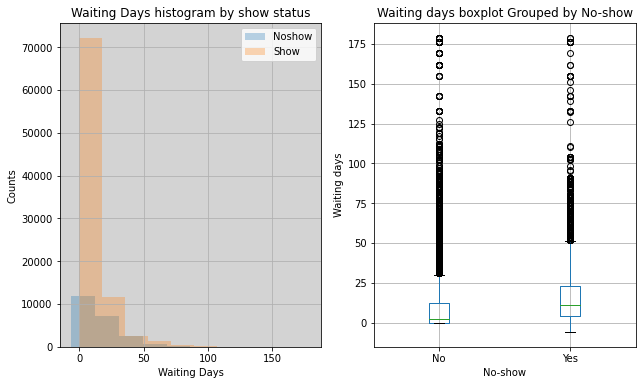

In [85]:
noshow['Waiting_days'] = noshow_waiting.values
mask = noshow['No-show']=='Yes'
noshow_df = noshow[mask]
show_df = noshow[~mask]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

noshow_df['Waiting_days'].hist(label='Noshow', alpha=0.3, ax=ax1)
show_df['Waiting_days'].hist(label='Show', alpha=0.3, ax=ax1)
ax1.set(title='Waiting Days histogram by show status', ylabel='Counts', xlabel='Waiting Days')
ax1.legend(loc='upper right')
ax1.set_facecolor('lightgray')

m_ = noshow.boxplot(column=['Waiting_days'], by='No-show', ax=ax2)
ax2.set(title='Waiting days boxplot Grouped by No-show', ylabel='Waiting days')
plt.suptitle('')
save_fig('Waiting_Days_histogram_by show_status')

For those no-show patients, their median waiting time was 11 days, while for the showed patients, their waiting time was 2 days. It indicated the longer the waiting time, the more likely patient decided to skip the appointment.

## No-show status by scholarship

**Question: Does the scholarship lead to high no-show chances?**


In [115]:
scholarship = pd.crosstab(index=noshow['No-show'], columns=noshow['Scholarship'], normalize='columns')
scholarship

Scholarship,0,1
No-show,,
No,0.801969,0.762637
Yes,0.198031,0.237363


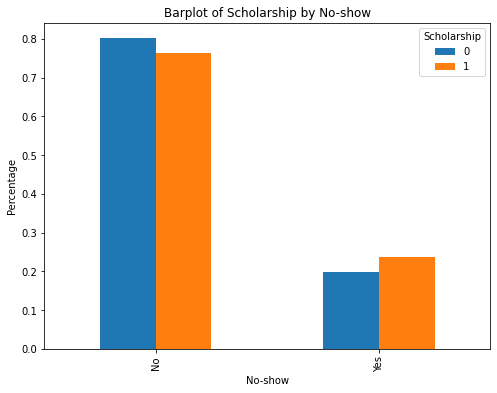

In [117]:
ax = scholarship.plot(kind='bar', figsize=(8, 6))
ax.set(title='Barplot of Scholarship by No-show', ylabel='Percentage')
save_fig('Barplot_of_Scholarship_by_No-show')

Patients who are sponsored by scholarship have 23.7% no-show rate, while those who have to pay by themselves entirely have no-show rate for 19.8%, almost 4% less than the sponsored ones. In general, those who need to pay for a service/product are more committed than those don't.

## No-show status by neighbourhood

**Question: Which neighbourhood has the highest no-show counts? Which neighbourhood has the lowest no-show percentage?**


In [132]:
noshow['Neighbourhood'].nunique()

81

In [149]:
neighbor = noshow.groupby('No-show')['Neighbourhood'].value_counts().unstack(level='No-show', fill_value=0)
neighbor['No-show%'] = ((neighbor['Yes']/neighbor.sum(axis=1))*100).round(2)
neighbor['ns%_rank'] = neighbor['No-show%'].rank(method='max', ascending=False) 

print('Average number of No-show appointment among all neighborhood: {}'.format(neighbor.loc[slice(None), 'Yes'].median()))
print('Average No-show percentage among all neighborhood:{}%'.format(neighbor['No-show%'].median()))

Average number of No-show appointment among all neighborhood: 179.0
Average No-show percentage among all neighborhood:19.76%


In [137]:
print('Top 5 Sorted By Number of No Show: ')
display(neighbor.sort_values(by=['Yes'], ascending=False).head(5))

Top 5 Sorted By Number of No Show: 


No-show,No,Yes,No-show%,ns%_rank
Neighbourhood,,,,
JARDIM CAMBURI,6252,1465,18.98,51.0
MARIA ORTIZ,4586,1219,21.00,29.0
ITARARÉ,2591,923,26.27,5.0
RESISTÊNCIA,3525,905,20.43,32.0
CENTRO,2631,703,21.09,26.0


Hospitals located at 'JARDIM CAMBURI' have the highest number of no-show appointments.

In [138]:
print('Top 5 Sorted By Percentage of No Show: ')
display(neighbor.sort_values(by=['No-show%'], ascending=False).head(5))

Top 5 Sorted By Percentage of No Show: 


No-show,No,Yes,No-show%,ns%_rank
Neighbourhood,,,,
ILHAS OCEÂNICAS DE TRINDADE,0,2,100.00,1.0
SANTOS DUMONT,907,369,28.92,2.0
SANTA CECÍLIA,325,123,27.46,3.0
SANTA CLARA,372,134,26.48,4.0
ITARARÉ,2591,923,26.27,5.0


Hospitals located at 'ILHAS OCEÂNICAS DE TRINDADE' have the highest no-show percentage. However, there were only 2 appointments scheduled in this neighborhood. 

In [140]:
print('Top 5 Sorted By Percentage of Showed Appointments: ')
display(neighbor.sort_values(by=['No-show%'], ascending=True).head(5))

Top 5 Sorted By Percentage of Showed Appointments: 


No-show,No,Yes,No-show%,ns%_rank
Neighbourhood,,,,
PARQUE INDUSTRIAL,1,0,0.00,81.0
ILHA DO BOI,32,3,8.57,80.0
AEROPORTO,7,1,12.50,79.0
MÁRIO CYPRESTE,317,54,14.56,78.0
SOLON BORGES,400,69,14.71,77.0


The 5 hospitals with low no-show rate are: PARQUE INDUSTRIAL, ILHA DO BOI, AEROPORTO, MÁRIO CYPRESTE, SOLON BORGES.

## No-show status by disease

**Question: Which disease has the highest no-show counts?**

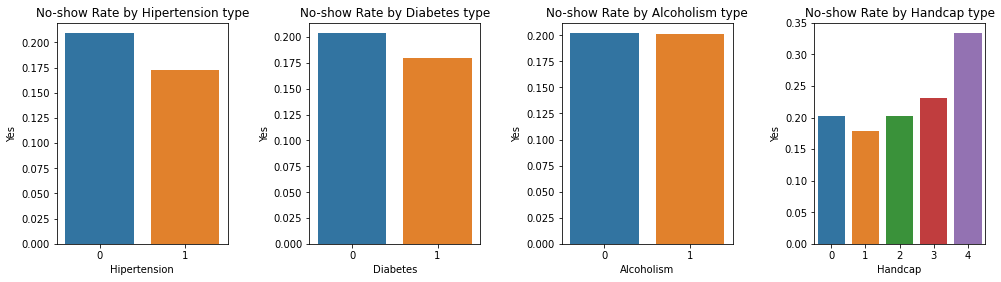

In [156]:
synthon = ['Hipertension', 'Diabetes', 'Alcoholism',	'Handcap']

fig, axes = plt.subplots(1, 4, figsize=(14, 4))

for i, feature in enumerate(synthon):

  grouping = noshow.groupby(feature)['No-show'].value_counts(normalize=True).unstack()
  sns.barplot(x=grouping.index, y=grouping['Yes'], ax=axes[i])
  axes[i].set(title='No-show Rate by ' + feature + ' type')

plt.tight_layout(True)
save_fig('No-show_Rate_by_Disease')

In [157]:
noshow['Handcap'].value_counts()

0    108283
1      2040
2       183
3        13
4         3
Name: Handcap, dtype: int64

Patients who have 'Hipertension' or 'Diabetes' have lower no-show rate than those don't. 'Alcoholism' appears to have no effect on no-show prediction being equally possible on the outcome. In addition, patiens with type 2, 3, 4 handcap are seemed to have no-show rate greater than 20%, higher than the average population no-show rate at 19.76%.

## No-show status by sms

**Question: Does the usage of sms reminder help to lower no-show percentage in general?**

In [165]:
grouping = noshow.groupby('SMS_received')['No-show'].value_counts(normalize='columns').unstack()
grouping

No-show,No,Yes
SMS_received,,
0,0.833022,0.166978
1,0.724255,0.275745


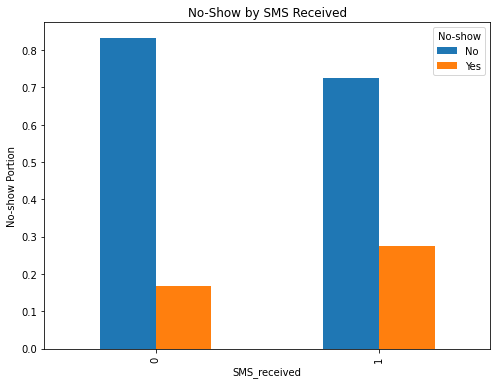

In [169]:
ax = grouping.plot(kind='bar', figsize=(8, 6))
ax.set(title='No-Show by SMS Received', ylabel='No-show Portion')
save_fig('No-Show_by_SMS_Received')

The table and barplots show patients who received sms turned out to have about 30% no-show, while this number was less than 20%. This outcome is quite shocking, because we assumed if patients who are reminded of the appointments should be more likely to turn up for the appointment. Apparently this was not the case. Possible reason is that if patients sign up for sms reminder, they are more likely to depend on the sms, hence not taking responsiblity to remind themselves diligently to attend the appointment.

# Conclusion

In this project, I analyzed the no-show status in different scopes, including waiting time, neighborhood, scholarship disease, and sms. In summary, long waiting-time, presence of scholarship, and use of sms service are seemingly destructive to the appoitment attention rate. We also identified the top 5 hospital locations that have the highest no-show rate and the top 5 hospital locations that have no-show rate much lower than average population.